# LSTM - vanilla

In [45]:
best_model = "best_model11.pt"

# Setup

In [46]:
import torch 

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# Load and analyze data

In [47]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [48]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


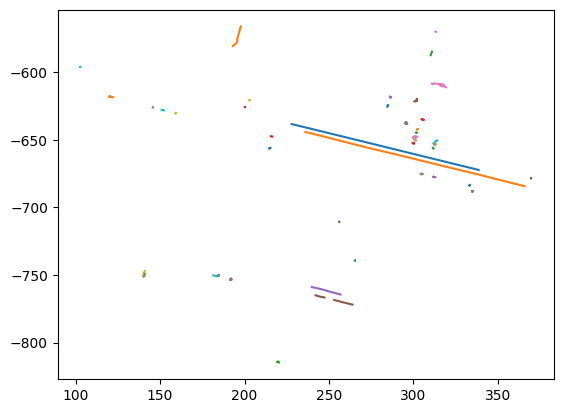

In [49]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

In [50]:
print(train_data.shape)
print(train_data[0, 0, 0, :])
# print(count(train_data[:, :, 0, 5])

(10000, 50, 110, 6)
[ 338.59322192 -672.21574762   -5.32538052    1.61518358    2.84662927
    0.        ]


In [51]:
from collections import Counter

# Object type mapping
object_types = [
    'vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 
    'static', 'background', 'construction', 'riderless_bicycle', 'unknown'
]

# Extract object_type column (index 5 in the last dimension)
object_type_data = train_data[:, :, :, 5]

# Flatten the array to get all object type values
all_object_types = object_type_data.flatten()

# Count occurrences
type_counts = Counter(all_object_types)

# Calculate total entries
total_entries = len(all_object_types)

# Create results dictionary
results = {}

print("Vehicle Type Distribution:")
print("=" * 50)

for i, type_name in enumerate(object_types):
    count = type_counts.get(i, 0)  # Get count for index i, default to 0
    percentage = (count / total_entries) * 100 if total_entries > 0 else 0
    
    results[type_name] = {
        'count': count,
        'percentage': percentage
    }
    
    print(f"{type_name:15}: {count:,} ({percentage:.2f}%)")

print("=" * 50)
print(f"Total entries: {total_entries:,}")

Vehicle Type Distribution:
vehicle        : 50,078,615 (91.05%)
pedestrian     : 1,836,973 (3.34%)
motorcyclist   : 61,317 (0.11%)
cyclist        : 181,504 (0.33%)
bus            : 313,890 (0.57%)
static         : 1,126,469 (2.05%)
background     : 794,206 (1.44%)
construction   : 314,377 (0.57%)
riderless_bicycle: 278,357 (0.51%)
unknown        : 14,292 (0.03%)
Total entries: 55,000,000


# Data Loaders

In [52]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [53]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene.copy()    # (agents=50, time_seq=110, 6)
        print(f'hist: {hist.shape}')
        # future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                # future[:, 0] *= -1

        # TODO: should i change the origin?
        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        # future = future / self.scale
        
        # Split into x and y
        

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),      # Input: (50, 110, 6)
            # y=future.type(torch.float32),                   # Target: (60, 2)
            # origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),  # (1, 2)
            # scale=torch.tensor(self.scale, dtype=torch.float32),            # Scalar
        )
        print(f'data_item.x: {data_item.x.shape}')

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Scale, Normalize, Augment, Create train and test data sequences, Create data loaders

In [54]:
# too slow
def createInputsAndLabels(train_data, sequence_len, stride = 1):
    input_seqs = []
    target_seqs = []
    
    number_of_scenes = train_data.shape[0]
    print(f'number_of_scenes: {number_of_scenes}')
    time_steps_per_scene = train_data.shape[2]
    print(f'time_steps_per_scene: {time_steps_per_scene}')
    
    for i in range(number_of_scenes):
        for j in range(sequence_len, time_steps_per_scene, stride):
            input_seq = train_data[i, :, j-sequence_len: j, :]
            target_seq = train_data[i, 0, j-sequence_len+1: j+1, :2]
            
            input_seqs.append(input_seq)
            target_seqs.append(target_seq)
    
    print(f'1 input_seq: {input_seqs[0].shape}')
    print(f'1 target_seq: {target_seqs[0].shape}')
    
    # input_seqs = torch.tensor(input_seqs).to(device)
    # target_seqs = torch.tensor(target_seqs).to(device)
    print(f'all input_seqs: {input_seqs.shape}')
    print(f'all target_seqs: {target_seqs.shape}')
    
    return input_seqs, target_seqs

In [79]:
# preallocate memory => faster
def createInputsAndLabels_vectorized(train_data, sequence_len, stride=1, augment=True, scale=10.0):
    """
    Vectorized version of createInputsAndLabels for better performance.
    
    Args:
        train_data: numpy array or tensor of shape (num_scenes, channels, time_steps, features)
        sequence_len: length of input sequences
        stride: step size for sliding window
    
    Returns:
        input_seqs: tensor of input sequences
        target_seqs: tensor of target sequences
    """
    # Convert to tensor if it's a numpy array
    if isinstance(train_data, np.ndarray):
        train_data = torch.from_numpy(train_data).float()
    
    number_of_scenes, objects, time_steps_per_scene, features = train_data.shape
    print(f'number_of_scenes: {number_of_scenes}')
    print(f'time_steps_per_scene: {time_steps_per_scene}')
    
    # Calculate number of sequences per scene
    valid_starts = torch.arange(sequence_len, time_steps_per_scene, stride)
    num_seqs_per_scene = len(valid_starts)
    total_sequences = number_of_scenes * num_seqs_per_scene
    
    if total_sequences == 0:
        print("Warning: No valid sequences found!")
        return torch.empty(0), torch.empty(0)
    
    # Pre-allocate output tensors - handle device properly
    # device = train_data.device if hasattr(train_data, 'device') else 'cpu'
    input_seqs = torch.zeros(total_sequences, objects, sequence_len, features, 
                           dtype=train_data.dtype)
    # TODO: should output be a sequence?
    target_seqs = torch.zeros(total_sequences, 2, 
                            dtype=train_data.dtype)
    origins = torch.zeros((total_sequences, 2), dtype=train_data.dtype, device=device)
    
    # Vectorized extraction using advanced indexing
    seq_idx = 0
    for scene_idx in range(number_of_scenes):
        # scale, normalize, augment
        scene = train_data[scene_idx]
        # Getting 50 historical timestamps and 60 future timestamps
        # hist = scene.copy()
        if augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                scene[..., :2] = scene[..., :2] @ R
                scene[..., 2:4] = scene[..., 2:4] @ R
                # future = future @ R
            if np.random.rand() < 0.5:
                scene[..., 0] *= -1
                scene[..., 2] *= -1
                # future[:, 0] *= -1

        # TODO: should i change the origin?
        # Use the last timeframe of the historical trajectory as the origin
        origin = scene[0, 49, :2]  # (2,)
        scene[..., :2] = scene[..., :2] - origin
        # future = future - origin

        # Normalize the historical trajectory and future trajectory
        scene[..., :4] = scene[..., :4] / scale
        
        # print(f'hist: {scene.shape}')
        
        for j in valid_starts:
            # Extract input sequence: [j-sequence_len:j]
            input_seqs[seq_idx] = scene[:, j-sequence_len:j, :]
            
            # Extract target sequence: [j-sequence_len+1:j+1, :2] from channel 0
            target_seqs[seq_idx] = scene[0, j, :2]
            
            origins[seq_idx] = origin
            
            seq_idx += 1
    
    # Move to specified device if needed (from your original code)
    # if 'device' in globals():
    # input_seqs = input_seqs.to(device)
    # target_seqs = target_seqs.to(device)
    
    print(f'1 input_seq: {input_seqs[0].shape}')
    print(f'1 target_seq: {target_seqs[0].shape}')
    print(f'all input_seqs: {input_seqs.shape}')
    print(f'all target_seqs: {target_seqs.shape}')
    
    return input_seqs, target_seqs, origins

In [56]:
# # fully vectorized => fastet but makes device freeze
# def createInputsAndLabels_fully_vectorized(train_data, sequence_len, stride=1):
#     """
#     Fully vectorized version using unfold for maximum performance.
    
#     Args:
#         train_data: numpy array or tensor of shape (num_scenes, channels, time_steps, features)
#         sequence_len: length of input sequences
#         stride: step size for sliding window
    
#     Returns:
#         input_seqs: tensor of input sequences
#         target_seqs: tensor of target sequences
#     """
#     # Convert to tensor if it's a numpy array
#     if isinstance(train_data, np.ndarray):
#         train_data = torch.from_numpy(train_data).float()
    
#     number_of_scenes, objects, time_steps_per_scene, features = train_data.shape
#     print(f'number_of_scenes: {number_of_scenes}')
#     print(f'time_steps_per_scene: {time_steps_per_scene}')
    
#     # Check if we have enough timesteps
#     if time_steps_per_scene < sequence_len + 1:
#         print("Warning: Not enough timesteps for the given sequence length!")
#         return torch.empty(0), torch.empty(0)
    
#     # Use unfold to create sliding windows efficiently
#     # unfold(dimension, size, step) creates sliding windows
#     unfolded = train_data.unfold(2, sequence_len + 1, stride)  # +1 to get target as well
#     # Shape: (num_scenes, objects, num_windows, features, sequence_len + 1)
    
#     # Remove windows that don't have enough future steps
#     if unfolded.size(2) == 0:
#         print("Warning: No valid sequences found!")
#         return torch.empty(0), torch.empty(0)
    
#     # Reshape to combine scenes and windows
#     num_windows = unfolded.size(2)
#     total_sequences = number_of_scenes * num_windows
    
#     # Extract input sequences (first sequence_len timesteps)
#     input_seqs = unfolded[:, :, :, :, :sequence_len].permute(0, 2, 1, 4, 3)
#     input_seqs = input_seqs.reshape(total_sequences, objects, sequence_len, features)
    
#     # Extract target sequences (last sequence_len timesteps, channel 0, first 2 features)
#     target_seqs = unfolded[:, 0, :, :2, 1:].permute(0, 2, 3, 1)
#     target_seqs = target_seqs.reshape(total_sequences, sequence_len, 2)
    
#     # Move to specified device if needed (from your original code)
#     if 'device' in globals():
#         input_seqs = input_seqs.to(device)
#         target_seqs = target_seqs.to(device)
    
#     print(f'1 input_seq: {input_seqs[0].shape}')
#     print(f'1 target_seq: {target_seqs[0].shape}')
#     print(f'all input_seqs: {input_seqs.shape}')
#     print(f'all target_seqs: {target_seqs.shape}')
    
#     return input_seqs, target_seqs

In [80]:
#  TODO: modify these
torch.manual_seed(251)
np.random.seed(42)

batch_size = 1000
sequence_len = 5
stride = 1
scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

In [82]:
# (train_data, sequence_len, stride=1, augment=True, scale=10.0):
train_input_seqs, train_target_seqs, train_origins = createInputsAndLabels_vectorized(train_data[:train_size], sequence_len, stride, augment=True, scale=scale)
val_input_seqs, val_target_seqs, val_origins = createInputsAndLabels_vectorized(train_data[train_size:], sequence_len, stride, augment=False, scale=scale)

train_dataset = torch.utils.data.TensorDataset(train_input_seqs, train_target_seqs, train_origins)
val_dataset = torch.utils.data.TensorDataset(val_input_seqs, val_target_seqs, val_origins)

# Data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

number_of_scenes: 9000
time_steps_per_scene: 110


/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_33351/1745041611.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scene[..., :2] = scene[..., :2] @ R
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_33351/1745041611.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scene[..., 2:4] = scene[..., 2:4] @ R


1 input_seq: torch.Size([50, 5, 6])
1 target_seq: torch.Size([2])
all input_seqs: torch.Size([945000, 50, 5, 6])
all target_seqs: torch.Size([945000, 2])
number_of_scenes: 1000
time_steps_per_scene: 110
1 input_seq: torch.Size([50, 5, 6])
1 target_seq: torch.Size([2])
all input_seqs: torch.Size([105000, 50, 5, 6])
all target_seqs: torch.Size([105000, 2])


In [89]:
print(f'train_input_seqs: {train_input_seqs.shape}')
print(f'train_target_seqs: {train_target_seqs.shape}')
print(f'train_target_seqs: {train_origins.shape}')
print(f'val_input_seqs: {val_input_seqs.shape}')
print(f'val_input_seqs: {val_input_seqs.shape}')
print(f'val_input_seqs: {val_origins.shape}')

print(train_origins[10:])
print(val_origins[10:])

train_input_seqs: torch.Size([945000, 50, 5, 6])
train_target_seqs: torch.Size([945000, 2])
train_target_seqs: torch.Size([945000, 2])
val_input_seqs: torch.Size([105000, 50, 5, 6])
val_input_seqs: torch.Size([105000, 50, 5, 6])
val_input_seqs: torch.Size([105000, 2])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='mps:0')
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='mps:0')


In [59]:
# test_input_seqs, val_target_seqs = createInputsAndLabels_vectorized(train_data[train_size:], sequence_len, stride, augment=False, scale=scale)

# test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
#                          collate_fn=lambda xs: Batch.from_data_list(xs))

# LSTM

In [60]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    # TODO: make input dim 5?
    # TODO: add more layers?
    def __init__(self, input_dim=6, hidden_dim=512, output_dim=2, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        # self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # TODO: different initialization method?
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    # TODO: add hidden dimension?
    def forward(self, x, hidden_state = None):
        # x = data.x
        # TODO: did the data loader batch it?
        # x = x.reshape(-1, 50, sequence_len, 6)  # (batch_size, num_agents, seq_len, input_dim)
        # print(f'forward function - x shape: {x.shape}')
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        # print(f'forward function - x shape ego only: {x.shape}')
        
        batch_size = x.size(0)

        if not hidden_state:
            h0, cell0 = self.__initialize_hidden_and_cell(batch_size)
            hidden_state = (h0, cell0)
        
        # Process through LSTM
        lstm_out, hidden_state = self.lstm(x, hidden_state)
        
        # lst_out shape: (batch_size, sequence_len, hidden_dim)
        
        # print(f'forward function - lstm out should be (batch_size, sequence_len, hidden_dim): {lstm_out.shape}')
        # Select output of the final time step from LSTM (last hidden state that is a summary of all those before it)
        features = lstm_out[:, -1, :]
        # features shape: (batch_size, hidden_dim)
        # print(f'forward function - features should be (batch_size, hidden_dim): {features.shape}')
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # print(f'forward function - out: {out.shape}')
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 2)
    
    def __initialize_hidden_and_cell(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0, cell0

In [61]:
# class VehicleOnlyLSTM(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):  # input_dim=5 (excluding object_type)
#         super(VehicleOnlyLSTM, self).__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
        
#         # Single LSTM for processing vehicle trajectories
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
#         # Prediction head
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(0.1)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
        
#         # Initialize weights properly
#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 nn.init.xavier_normal_(param)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0.0)
    
#     def get_vehicle_data(self, x):
#         """
#         Extract all vehicles (object_type == 0) and concatenate their trajectories
        
#         Args:
#             x: tensor of shape (batch_size, num_agents, seq_len, input_dim)
            
#         Returns:
#             vehicle_trajectories: tensor of shape (total_vehicles, seq_len, input_dim-1)
#             batch_indices: tensor indicating which batch each vehicle belongs to
#         """
#         batch_size, num_agents, seq_len, _ = x.shape
        
#         # Extract object_type (last dimension, index 5)
#         object_types = x[:, :, :, 5]  # (batch_size, num_agents, seq_len)
        
#         # Create mask for vehicles (object_type == 0)
#         # Check if any timestep in the trajectory has object_type == 0
#         vehicle_mask = (object_types == 0).any(dim=2)  # (batch_size, num_agents)
        
#         # Collect all vehicle trajectories
#         vehicle_trajectories = []
#         batch_indices = []
        
#         for batch_idx in range(batch_size):
#             # Get indices of vehicles in this batch
#             vehicle_indices = torch.where(vehicle_mask[batch_idx])[0]
            
#             if len(vehicle_indices) > 0:
#                 # Extract vehicle data (excluding object_type dimension)
#                 batch_vehicles = x[batch_idx, vehicle_indices, :, :5]  # (num_vehicles, seq_len, 5)
#                 vehicle_trajectories.append(batch_vehicles)
                
#                 # Track which batch each vehicle belongs to
#                 batch_indices.extend([batch_idx] * len(vehicle_indices))
        
#         if len(vehicle_trajectories) > 0:
#             # Concatenate all vehicles
#             all_vehicles = torch.cat(vehicle_trajectories, dim=0)  # (total_vehicles, seq_len, 5)
#             batch_indices = torch.tensor(batch_indices, device=x.device, dtype=torch.long)
#         else:
#             # No vehicles found - create dummy data
#             all_vehicles = torch.zeros(1, seq_len, 5, device=x.device, dtype=x.dtype)
#             batch_indices = torch.zeros(1, device=x.device, dtype=torch.long)
        
#         return all_vehicles, batch_indices
    
#     def forward(self, data):
#         x = data.x
#         x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
#         batch_size = x.shape[0]
        
#         # Extract all vehicle trajectories
#         vehicle_trajectories, batch_indices = self.get_vehicle_data(x)  # (total_vehicles, seq_len, 5)
        
#         # Process all vehicles through single LSTM
#         lstm_out, _ = self.lstm(vehicle_trajectories)  # (total_vehicles, seq_len, hidden_dim)
        
#         # Extract final hidden state for each vehicle
#         vehicle_features = lstm_out[:, -1, :]  # (total_vehicles, hidden_dim)
        
#         # Aggregate features by batch using average pooling
#         output_features = torch.zeros(batch_size, self.hidden_dim, device=x.device, dtype=x.dtype)
        
#         for batch_idx in range(batch_size):
#             # Find vehicles belonging to this batch
#             mask = (batch_indices == batch_idx)
#             if mask.any():
#                 # Average the features of all vehicles in this batch
#                 batch_vehicle_features = vehicle_features[mask]  # (num_vehicles_in_batch, hidden_dim)
#                 output_features[batch_idx] = batch_vehicle_features.mean(dim=0)
        
#         # Process through prediction head
#         features = self.relu(self.fc1(output_features))
#         features = self.dropout(features)
#         out = self.fc2(features)
        
#         # Reshape to (batch_size, 60, 2)
#         return out.view(-1, 60, 2)

# Train

In [121]:
from tqdm import tqdm

def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        n = 0
        running_loss = 0
        
        # print(f'train_dataloader: {train_dataloader.shape}')
        # print(f'train_dataloader: {type(train_dataloader)}')
        # print(f'val_dataloader: {val_dataloader.shape}')
        # print(f'val_dataloader: {type(val_dataloader)}')
        
        # for inputs, targets, origin in tqdm(train_dataloader, desc=f"Epoch {epoch:03d} Batches", leave=False):
        for batch_idx, (inputs, targets, origins) in enumerate(train_dataloader):
            # print(f'batch: {batch_idx}')
            inputs = inputs.to(device)
            targets = targets.to(device)
            origins = origins.to(device)
            
            # inputs = batch.x
            # targets = batch.y
            
            # print(f'training fn - inputs: {inputs.shape}')
            # print(f'training fn - targets: {targets.shape}')
            
            hidden_state = None
            optimizer.zero_grad()
            
            pred = model(inputs, hidden_state)
            # print(f'pred shape: {pred.shape}')
            
            y = targets
            # print(f'y shape: {y.shape}')
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            running_loss += loss.item()
            n += 1
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            loss.backward()
            
            # TODO: remove?
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
        
        # Skip epoch if no valid batches
        if n == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        avg_loss = running_loss / n
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        # TODO: add for validation
        with torch.no_grad():
            for batchidx, (inputs, targets, origins) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                origins = origins.to(device)
                # print(f'training - origin: {origins}')
                
                # print(f"pred[0]: {pred[0]}")
                # print(f"origins[0]: {origins[0]}")
                # print(f"unnorm pred[0]: {(pred[0] * scale + origins[0])}")

                hidden_state = None
                pred = model(inputs, hidden_state)
                y = targets
                
                # Store sample for debugging
                if batchidx == 0 and sample_input is None:
                    sample_input = inputs[0]
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * scale + origins
                y_unnorm = y * scale + origins
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {running_loss:.4f} | Val Loss {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        
        # # TODO: add later for checking
        # # Debug output - first 3 predictions vs targets
        # # if epoch % 5 == 0:
        # #     tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
        # #     tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
        # #     # Check if model weights are changing
        # #     if epoch > 0:
        # #         weight_change = False
        # #         for name, param in model.named_parameters():
        # #             if param.requires_grad:
        # #                 initial_param = initial_state_dict[name]
        # #                 if not torch.allclose(param, initial_param, rtol=1e-4):
        # #                     weight_change = True
        # #                     break
        # #         if not weight_change:
        # #             tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [122]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=6, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 9.07
        # lr = 0.01 => 9.18
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for (inputs, targets, origins) in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            origins = origins.to(device)
            
            pred = model(inputs)
            y = targets
            
            # Unnormalize
            pred = pred * scale + origins
            y = y * scale + origins
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [ ]:
train_and_evaluate_model()

# sample = next(iter(train_dataloader))

# print(f"Type of sample: {type(sample)}")

# if isinstance(sample, tuple):
#     print(f"Sample is a tuple with {len(sample)} elements")
#     for i, item in enumerate(sample):
#         print(f" - Element {i}: type={type(item)}")
#         if isinstance(item, torch.Tensor):
#             print(f"   shape={item.shape}")
#         elif hasattr(item, '__dict__'):
#             print(f"   keys={item.__dict__.keys()}")
# elif hasattr(sample, '__dict__'):
#     print(f"Sample has attributes: {sample.__dict__.keys()}")
# else:
#     print("Sample is of unknown structure.")


Epoch:   1%|          | 1/100 [00:27<46:01, 27.89s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 55.0111 | Val Loss 0.0025 | Val MAE 0.1968 | Val MSE 0.1209
Validation improved: inf -> 0.002467


Epoch:   2%|▏         | 2/100 [00:55<45:34, 27.91s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 6.0344 | Val Loss 0.0010 | Val MAE 0.1404 | Val MSE 0.0513
Validation improved: 0.002467 -> 0.001047


Epoch:   3%|▎         | 3/100 [01:24<45:40, 28.25s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 5.6607 | Val Loss 0.0012 | Val MAE 0.1413 | Val MSE 0.0592


Epoch:   4%|▍         | 4/100 [01:54<46:18, 28.94s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 5.6867 | Val Loss 0.0009 | Val MAE 0.1334 | Val MSE 0.0430
Validation improved: 0.001047 -> 0.000878


Epoch:   5%|▌         | 5/100 [02:24<46:27, 29.34s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 5.4270 | Val Loss 0.0012 | Val MAE 0.1562 | Val MSE 0.0576


Epoch:   6%|▌         | 6/100 [02:56<47:13, 30.14s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 5.2774 | Val Loss 0.0021 | Val MAE 0.1736 | Val MSE 0.1023


Epoch:   7%|▋         | 7/100 [03:25<46:17, 29.86s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 5.2969 | Val Loss 0.0012 | Val MAE 0.1566 | Val MSE 0.0564


Epoch:   8%|▊         | 8/100 [03:56<46:32, 30.36s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 5.1388 | Val Loss 0.0018 | Val MAE 0.1640 | Val MSE 0.0898


Epoch:   9%|▉         | 9/100 [04:24<44:45, 29.51s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 5.1349 | Val Loss 0.0009 | Val MAE 0.1382 | Val MSE 0.0452


Epoch:  10%|█         | 10/100 [04:53<43:48, 29.21s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 5.0532 | Val Loss 0.0006 | Val MAE 0.1101 | Val MSE 0.0318
Validation improved: 0.000878 -> 0.000650


Epoch:  11%|█         | 11/100 [05:21<42:53, 28.92s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 5.0238 | Val Loss 0.0008 | Val MAE 0.1294 | Val MSE 0.0402


Epoch:  12%|█▏        | 12/100 [05:48<41:27, 28.27s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 4.9702 | Val Loss 0.0014 | Val MAE 0.1977 | Val MSE 0.0699


Epoch:  13%|█▎        | 13/100 [06:14<40:19, 27.81s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 4.8604 | Val Loss 0.0007 | Val MAE 0.1214 | Val MSE 0.0359


Epoch:  14%|█▍        | 14/100 [06:44<40:45, 28.43s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 4.8872 | Val Loss 0.0006 | Val MAE 0.1121 | Val MSE 0.0304
Validation improved: 0.000650 -> 0.000620


Epoch:  15%|█▌        | 15/100 [07:15<41:23, 29.22s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 4.7927 | Val Loss 0.0005 | Val MAE 0.1033 | Val MSE 0.0256
Validation improved: 0.000620 -> 0.000522


Epoch:  16%|█▌        | 16/100 [07:44<40:39, 29.04s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 4.7616 | Val Loss 0.0004 | Val MAE 0.1034 | Val MSE 0.0217
Validation improved: 0.000522 -> 0.000442


Epoch:  17%|█▋        | 17/100 [08:13<40:04, 28.97s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 4.7626 | Val Loss 0.0005 | Val MAE 0.1013 | Val MSE 0.0226


Epoch:  18%|█▊        | 18/100 [08:43<39:58, 29.25s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 4.7254 | Val Loss 0.0002 | Val MAE 0.0699 | Val MSE 0.0117
Validation improved: 0.000442 -> 0.000238


Epoch:  19%|█▉        | 19/100 [09:10<38:54, 28.82s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 4.7003 | Val Loss 0.0009 | Val MAE 0.1493 | Val MSE 0.0461


Epoch:  20%|██        | 20/100 [09:40<38:39, 29.00s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 4.6520 | Val Loss 0.0002 | Val MAE 0.0788 | Val MSE 0.0114
Validation improved: 0.000238 -> 0.000232


# Final Pred

In [11]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto12.csv', index=True)